#Generación de texto con LSTM

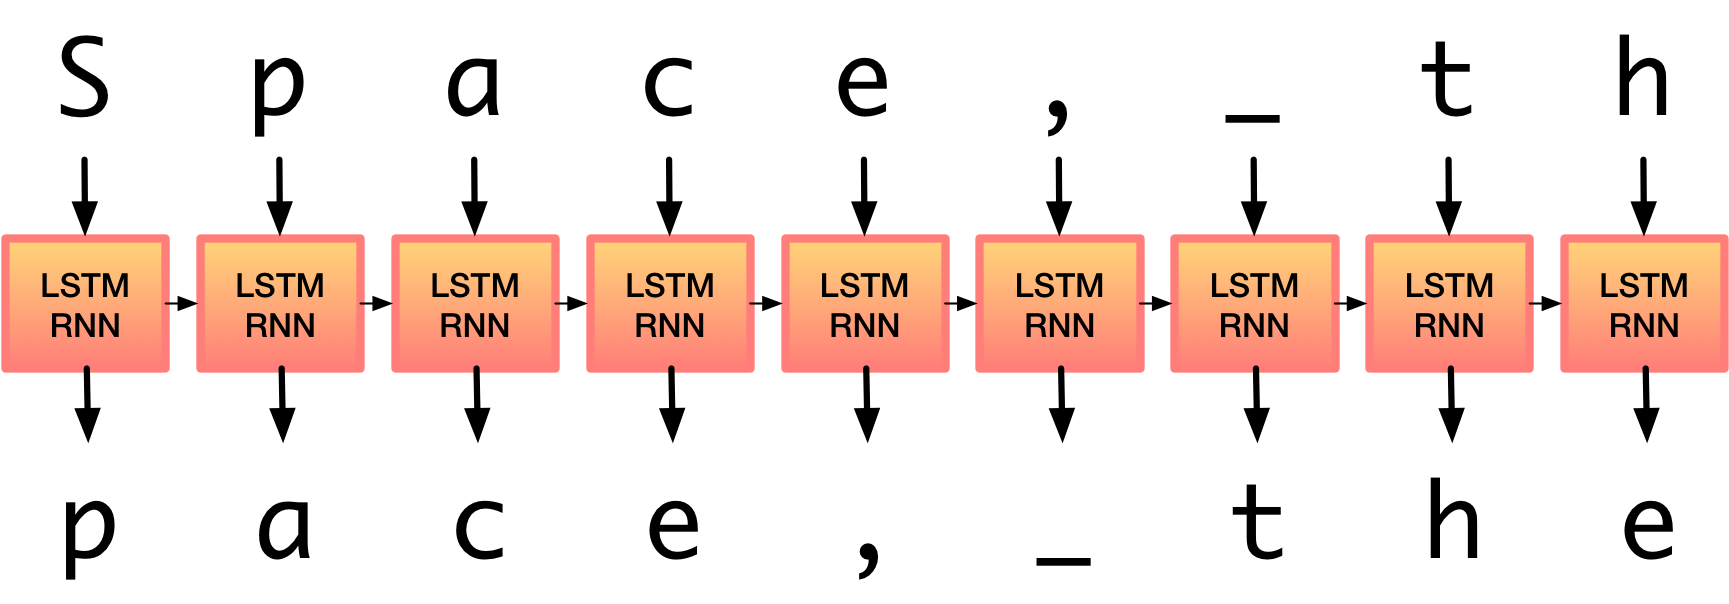

In [ ]:
#Ejemplo basado en: https://keras.io/examples/generative/lstm_character_level_text_generation/
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import io

Preparamos el dataset.
Podemos descargarnos nuestros propios libros en: https://www.gutenberg.org/browse/languages/es

In [ ]:
path = keras.utils.get_file(
    "nietzsche.txt", origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt"
)

with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
#text = open("libro.txt").read() # PARA PONER NUESTROS LIBROS
text = text.replace("\n", " ")  # We remove newlines chars for nicer display
print("Tamaño del corpus (caracteres del libro):", len(text))

#podemos bajarnos libros de prueba en: https://www.gutenberg.org/browse/languages/es

# Caracteres únicos en el texto
chars = sorted(list(set(text)))
print("Total de caracteres únicos:", len(chars))

# Creamos un diccionario para mapear caracteres a valores numéricos y viceversa
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# Cortamos el texto en secuencias semi-redundantes de longitud maxlen
maxlen = 40  # Longitud de cada secuencia
step = 3     # Desplazamiento entre secuencias
sentences = []   # Lista para almacenar las secuencias
next_chars = []  # Lista para almacenar los caracteres siguientes de cada secuencia
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])   # Agregamos la secuencia actual
    next_chars.append(text[i + maxlen])      # Agregamos el siguiente caracter después de la secuencia
print("Número de secuencias:", len(sentences))

# Convertimos las secuencias y los caracteres siguientes en representaciones one-hot
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=bool)  # Entradas (secuencias)
y = np.zeros((len(sentences), len(chars)), dtype=bool)           # Objetivos (caracteres siguientes)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1  # Marcamos la posición del caracter en la secuencia como 1
    y[i, char_indices[next_chars[i]]] = 1  # Marcamos el caracter siguiente como 1


Preparamos el modelo

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Entrenamos el modelo

In [ ]:
epochs = 40
batch_size = 128

# Iteramos sobre cada época de entrenamiento
for epoch in range(epochs):
    # Ajustamos el modelo en cada época con los datos de entrada (x) y objetivos (y)
    model.fit(x, y, batch_size=batch_size, epochs=1)
    print()
    print("Generating text after epoch: %d" % epoch)

    # Seleccionamos un índice de inicio aleatorio en el texto
    start_index = random.randint(0, len(text) - maxlen - 1)

    # Iteramos sobre diferentes niveles de diversidad (variabilidad) para generar texto
    #Cuando el valor de diversity es bajo (por ejemplo, cerca de 0), el modelo tiende a generar texto más predecible
    # y repetitivo, ya que está más influenciado por las predicciones más probables.
    #En contraste, cuando el valor de diversity es alto (por ejemplo, cerca de 1),
    #el modelo se vuelve más audaz y puede generar texto más variado y creativo,
    #ya que está más dispuesto a explorar opciones menos probables.
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print("...Diversity:", diversity)

        generated = ""  # Cadena para almacenar el texto generado
        sentence = text[start_index : start_index + maxlen]  # Tomamos una secuencia de texto como semilla
        # Podéis poner una frase personalizada
        #sentence = "it is a truth universally acknowledged, "
        print('...Generating with seed: "' + sentence + '"')

        # Generamos texto iterativamente
        for i in range(100):
            x_pred = np.zeros((1, maxlen, len(chars)))  # Creamos una matriz para la entrada
            # Convertimos la secuencia actual en representación one-hot
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.0
            # Predecimos el siguiente carácter utilizando el modelo
            preds = model.predict(x_pred, verbose=0)[0]
            # Muestreamos el siguiente carácter de acuerdo a las predicciones y la diversidad
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]  # Convertimos el índice en el carácter correspondiente
            sentence = sentence[1:] + next_char  # Actualizamos la secuencia eliminando el primer carácter y agregando el siguiente
            generated += next_char  # Agregamos el siguiente carácter al texto generado

        print("...Generated: ", generated)  # Mostramos el texto generado
        print()
